# Motor RNNs

contact: steeve.laquitaine@epfl.ch

Heavily inspired from [Feulner & Clopath, 2021](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008621)

## Setup

In [1]:
# import python packages
import os
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from IPython import display

### For google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# @title Set the project path
proj_path = "/content/drive/MyDrive/2025 NMA computational neuroscience/Motor RNN project" # need to modify the dir
if not os.path.exists(proj_path):
  os.makedirs(proj_path)

# set the directories where the results will be saved
savedir = os.path.join(proj_path, 'data/')

if not os.path.exists(savedir):
  os.makedirs(savedir)

### For IDE

In [62]:
# @title Set the project path
proj_path = os.getcwd() # need to modify the dir
if not os.path.exists(proj_path):
  os.makedirs(proj_path)

# set the directories where the results will be saved
savedir = os.path.join(proj_path, 'data/')

if not os.path.exists(savedir):
  os.makedirs(savedir)

### Function import

In [60]:
import sys
sys.path.append(proj_path)
import utils
from utils.network import RNN, save_RNN, save_RNN_sinewave
from utils.bciDecoder import train_reaching_decoder, create_reaching_task_decoder, train_force_exertion_decoder, \
    get_feedback_weights, get_cost, get_manifold, save_reaching_manifold, transform_reaching, simulate_reaching
from utils.task import create_reaching_task_stimuli, create_reaching_task_targets, plot_reaching_task_stimuli, \
    plot_reaching_task_targets

In [59]:
import importlib
importlib.reload(utils)
import utils.bciDecoder
importlib.reload(utils.bciDecoder)
import utils.task
importlib.reload(utils.task)
import utils.network
importlib.reload(utils.network)

<module 'utils.network' from 'g:\\My Drive\\2025 NMA computational neuroscience\\Motor RNN project\\utils\\network.py'>

### Data loading

In [ ]:
# @title Load the data from .npy file
results_name = 'reaching_xperiment_2'
relearning_results_name = 'reaching_relearning_results'
results_path = os.path.join(savedir, results_name + '.npy')
relearning_results_path = os.path.join(savedir, relearning_results_name + '.npy')
data = np.load(results_path, allow_pickle=True).item()
relearning_data = np.load(relearning_results_path, allow_pickle=True).item()

In [58]:
relearning_data.keys()

dict_keys(['manifold', 'perturbations'])

## Create task 1: "reaching"

In [ ]:
# @title set parameters
# TODO: create dictionary

seed_id = 2                 # random seed for this simulation
np.random.seed(seed_id)

results_name = 'reaching_exp_' + str(seed_id)
relearning_results_name = 'reaching_relearning_' + str(seed_id)

# time parameters
dt = 0.01                   # time discretization (secs, see paper table 1)
T = 2                       # trial duration (secs, see paper table 1)
time = np.arange(0, T, dt)
tsteps = len(time)          # number of time steps within a trial
pulse_length = int(0.2/dt)  # pulse length in number of timesteps

# network parameters
N = 800                     # RNN number of units
g = 1.5                     # RNN recurrent connection strengths (a.u)
p = 0.1                     # RNN connection probability
tau = 0.1                   # unit time constant tau (secs)
N_OUTPUT_UNITS = 2          # number of output units (2 for x and y)

# task parameters
targets = 6                 # number of reaching targets
stimulus_type = 'constant'  # constant, linear, normal
target_max = 0.2            # 0.2 or 0.01
n_learning1_trials = 80     # initial network learning
delta = 20.
relearning_trials = 80      # relearning
deltarec = 20.

# analyses parameters
manifold_trials = 50        # manifold calculation
reduced_dim = 10

In [12]:
# @title Create stimuli and targets

# create stimuli and plot
stimulus = create_reaching_task_stimuli(tsteps, pulse_length, twod=False)
# plot_reaching_task_stimuli(stimulus, targets, tsteps, T)

# create target (targets x timesteps x 2D coordinates) and plot
target = create_reaching_task_targets(
    tsteps,
    pulse_length,
    n_targets=targets,
    stype=stimulus_type,
    target_max=target_max
    )
# plot_reaching_task_targets(target, tsteps, T)

In [13]:
# @title build and train the network
# create and save RNN encoder
reaching_network = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
save_RNN(reaching_network, savedir)

# create feedforward decoder from RNN to (x,y) output units
reaching_decoder = create_reaching_task_decoder(reaching_network,
                                                target_max, n_output_units=N_OUTPUT_UNITS)

# create feedback weights from (x,y) output units back to RNN
reaching_feedback = get_feedback_weights(reaching_decoder)

# train and save the RNN encoder weights (learn the task)
reaching_loss = reaching_network.relearn(n_learning1_trials, stimulus,
                                         pulse_length, reaching_decoder,
                                         reaching_feedback, target, delta=delta)
np.save(f'{savedir}W_stabilized_reaching', reaching_network.W)
w1_reaching = reaching_network.W.copy()

Loss in Trial 1 is 0.36486
Loss in Trial 2 is 0.53443
Loss in Trial 3 is 0.07616
Loss in Trial 4 is 0.32136
Loss in Trial 5 is 0.40796
Loss in Trial 6 is 0.52334
Loss in Trial 7 is 0.12490
Loss in Trial 8 is 0.16206
Loss in Trial 9 is 0.05343
Loss in Trial 10 is 0.30051
Loss in Trial 11 is 0.64470
Loss in Trial 12 is 0.10505
Loss in Trial 13 is 0.42285
Loss in Trial 14 is 0.18380
Loss in Trial 15 is 0.14192
Loss in Trial 16 is 0.12791
Loss in Trial 17 is 0.47923
Loss in Trial 18 is 0.11559
Loss in Trial 19 is 0.35033
Loss in Trial 20 is 0.08278
Loss in Trial 21 is 0.06807
Loss in Trial 22 is 0.06301
Loss in Trial 23 is 0.09566
Loss in Trial 24 is 0.12736
Loss in Trial 25 is 0.23735
Loss in Trial 26 is 0.23559
Loss in Trial 27 is 0.17402
Loss in Trial 28 is 0.08763
Loss in Trial 29 is 0.17927
Loss in Trial 30 is 0.14406
Loss in Trial 31 is 0.08725
Loss in Trial 32 is 0.06780
Loss in Trial 33 is 0.12969
Loss in Trial 34 is 0.29347
Loss in Trial 35 is 0.06320
Loss in Trial 36 is 0.04275
L

In [19]:
# get the RNN's manifold
manifold_out = get_manifold(reaching_network, manifold_trials, stimulus, pulse_length)

# train the decoder
W_bci4, l4 = train_reaching_decoder(manifold_out["xi2"][:, :, :reduced_dim],
                                    target[:, pulse_length:, :],
                                    manifold_out["order"],
                                    n_output_units=N_OUTPUT_UNITS)

# transform
transformed = transform_reaching(reaching_network, manifold_out,
                                 W_bci4, reduced_dim, target, pulse_length, n_output_units=N_OUTPUT_UNITS)

In [ ]:
# @title Save run data
# format and save data for this run
run_data = {
    'params':{
        'dt':dt,
        'T':T,
        'time':time,
        'tsteps':tsteps,
        'pulse_length':pulse_length,
        'manifold_trials':manifold_trials,
        'target_max':target_max,
        'stimulus_type':stimulus_type,
        'N':N,
        'tau':tau,
        'g':g,
        'p':p
        },
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{
        'learning_trials':n_learning1_trials,
        'delta':delta,
        'decoder':reaching_decoder,
        'feedback':reaching_feedback,
        'stabilize_loss':reaching_loss
        },
    'manifold':{
        'activity':manifold_out["activity"],
        'activity2':manifold_out["activity_reshaped"],
        'xi':manifold_out["xi"],
        'xi2':manifold_out["xi2"],
        'cov':manifold_out["cov"],
        'ev':manifold_out["ev"],
        'evec':manifold_out["evec"],
        'pr':manifold_out["pr"],
        'order': manifold_out["order"]
        },
    'decoding':{
        'reduced_dim': reduced_dim,
        'weights': W_bci4,
        'loss':l4
        }
        }
np.save(f'{savedir}reaching_experiment_results_2', run_data)

# save manifold data separately, saves the relearning results under relearning_results_name
save_reaching_manifold(run_data, transformed, savedir, relearning_results_name)

### simulate reaching

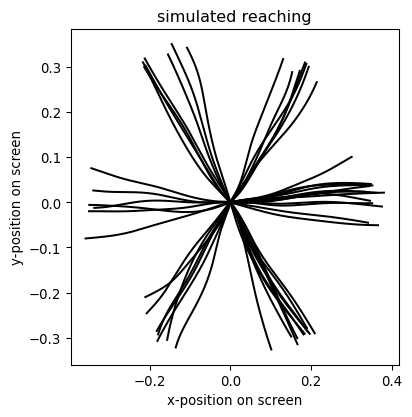

In [61]:
# simulate reaching
trajectories = simulate_reaching(savedir, dt, manifold_trials, relearning_results_name)  

## Create task 2: "force"

Don't hesitate to use some of the utils functions that have been implemented for this tasks under the "force" task section.

Can you think of other tasks to test?